<a href="https://colab.research.google.com/github/bibird0112/Transformer_vision_for_classification/blob/main/VisionTransformer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision.ops import StochasticDepth as DropPath
import math
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image

# Training
import torchvision.utils as vutils
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torch.amp import autocast, GradScaler

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# ============================================
#
# The network trained before can only achieve accuracy under 84% on test dataset.
# In order to improve these performances, we consider a deeper network
# So we condisder different technics to improve network training,
#
# ============================================

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()

        assert d_model % n_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.n_heads = n_heads # Number of attention heads
        self.d_k = d_model // n_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):

        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        output = self.W_o(self.combine_heads(attn_output))
        return output

class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_channels = n_channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  def forward(self, x):

    x = self.linear_project(x)
    x = x.flatten(2)
    x = x.transpose(1, 2)

    return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        # Learnable CLS token for classification [1, 1, d_model]
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Create position indices: [0, 1, 2, ..., max_seq_length-1] → [max_seq_length, 1]
        position = torch.arange(max_seq_length).unsqueeze(1)

        # Compute frequency terms: [1, 10000^(-2/d), 10000^(-4/d), ..., 10000^(-(d-2)/d)]
        # Different frequencies for different dimensions → [d_model//2]
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # Initialize positional encoding matrix [max_seq_length, d_model]
        pe = torch.zeros(max_seq_length, d_model)

        # Even dimensions (0, 2, 4, ...): use sine
        # PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)

        # Odd dimensions (1, 3, 5, ...): use cosine
        # PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (saved but not trained) → [1, max_seq_length, d_model]
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [batch_size, num_patches, d_model]

        # Expand CLS token for the whole batch → [batch_size, 1, d_model]
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Prepend CLS token: [batch_size, num_patches+1, d_model]
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding (truncated to sequence length)
        x = x + self.pe[:, :x.size(1)]

        return x  # [batch_size, num_patches+1, d_model]

# ============================================
# Transformer encoder modified for droppath and stochastic depth
# ============================================

class TransformerEncoder2(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4, dropout=0.1, drop_path=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.drop_path1 = DropPath(p=drop_path, mode="row") if drop_path > 0. else nn.Identity()

        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * r_mlp, d_model),
            nn.Dropout(dropout),
        )
        self.drop_path2 = DropPath(p=drop_path, mode="row") if drop_path > 0. else nn.Identity()

    def forward(self, x):
        # Attention block with DropPath
        x_norm = self.ln1(x)
        attn_out = self.dropout1(self.mha(x_norm, x_norm, x_norm))
        x = x + self.drop_path1(attn_out)

        # MLP block with DropPath
        x_norm = self.ln2(x)
        mlp_out = self.mlp(x_norm)
        x = x + self.drop_path2(mlp_out)
        return x

# ============================================
# Vision transformer modified for droppath and stochastic depth
# ============================================

class VisionTransformer2(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels,
                 n_heads, n_layers, dropout=0.1, drop_path_rate=0.1):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        # Patch Embedding
        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)

        # Positional Encoding with learnable cls token
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)

        # Stochastic depth - linearly increase drop rate
        # The deeper the layer the less chance it has to be dropped
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]

        # Transformer Encoders with increasing DropPath
        self.transformer_encoder = nn.ModuleList([
            TransformerEncoder2(
                self.d_model,
                self.n_heads,
                dropout=dropout,
                drop_path=dpr[i]
            ) for i in range(n_layers)
        ])

        # Final norm
        self.norm = nn.LayerNorm(self.d_model)

        # Classification head with dropout
        self.head_dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.d_model, self.n_classes)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)

        # Pass through transformer layers
        for encoder in self.transformer_encoder:
            x = encoder(x)

        x = self.norm(x)

        # Classification token
        x = self.head_dropout(x[:, 0])
        x = self.classifier(x)

        return x

In [ ]:
# ============================================
# Mixup data augmentation
# ============================================

def mixup_data(x, y, alpha=0.2):
    """Apply mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ============================================
# Cutmix data augmentation
# ============================================

def cutmix_data(x, y, alpha=1.0, cutmix_prob=0.5):
    """Apply CutMix augmentation"""
    if np.random.rand() > cutmix_prob:
        return x, y, y, 1.0

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)

    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_test_image_normalized(dataset, idx=0):
    """Display image from test_set (already normalized)"""
    img, label = dataset[idx]

    img = img.numpy().transpose(1, 2, 0)  # [C, H, W] → [H, W, C]

    plt.imshow(img)
    plt.title(f'Label: {classes[label]}')
    plt.axis('off')
    plt.show()

def show_test_grid(dataset, indices=None, grid_size=(3, 3)):
    """Display multiple test images in a grid"""
    if indices is None:
        indices = np.random.choice(len(dataset), grid_size[0] * grid_size[1], replace=False)

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.flatten()


    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        img = img.numpy().transpose(1, 2, 0)  # [C, H, W] → [H, W, C]

        axes[i].imshow(img)
        axes[i].set_title(f'{classes[label]}', fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

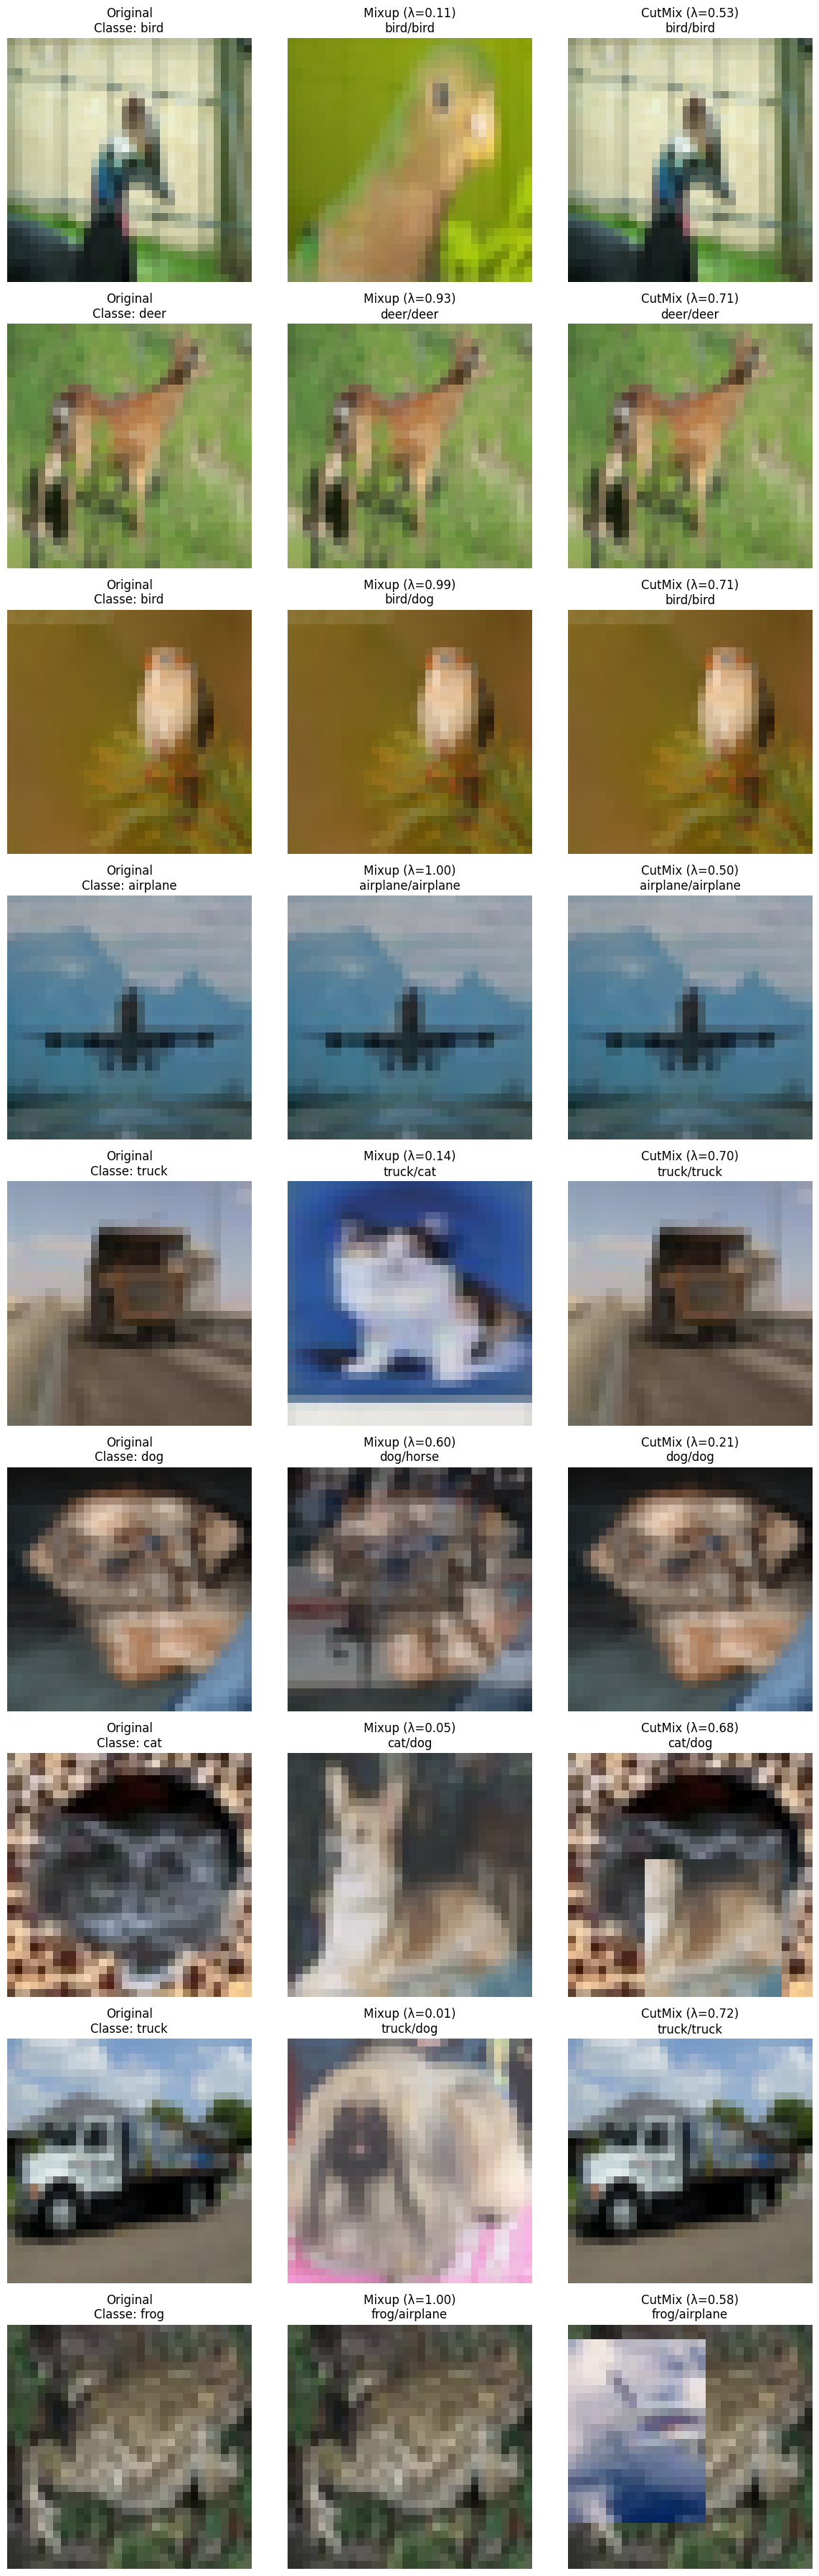

In [ ]:
test_transform = T.Compose([
    T.ToTensor()
])

test_set = CIFAR10(
    root="./../datasets", train=False, download=True, transform=test_transform
)

num_samples = 9
rows = num_samples
fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))

if rows == 1:
  axes = axes.reshape(1, -1)

# Classes CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(num_samples):
  # Obtain 2 random images
  idx1 = np.random.randint(len(test_set))
  idx2 = np.random.randint(len(test_set))
  if idx1 == idx2:
    idx2 = (idx2 + 1) % len(test_set)

  img1, label1 = test_set[idx1]
  img2, label2 = test_set[idx2]

  # Convert in batch
  x = torch.stack([img1, img2])
  y = torch.tensor([label1, label2])

  # Original image
  axes[i, 0].imshow(img1.permute(1, 2, 0))
  axes[i, 0].set_title(f'Original\nClasse: {classes[label1]}')
  axes[i, 0].axis('off')

  # Mixup
  mixed_x, y_a, y_b, lam = mixup_data(x, y, alpha=0.2)
  mixup_img = mixed_x[0].permute(1, 2, 0).cpu().numpy()
  mixup_img = np.clip(mixup_img, 0, 1)

  axes[i, 1].imshow(mixup_img)
  axes[i, 1].set_title(f'Mixup (λ={lam:.2f})\n{classes[y_a[0]]}/{classes[y_b[0]]}')
  axes[i, 1].axis('off')

  # CutMix
  cutmix_x, y_a, y_b, lam = cutmix_data(x.clone(), y, alpha=1.0, cutmix_prob=1.0)
  cutmix_img = cutmix_x[0].permute(1, 2, 0).cpu().numpy()
  cutmix_img = np.clip(cutmix_img, 0, 1)

  axes[i, 2].imshow(cutmix_img)
  axes[i, 2].set_title(f'CutMix (λ={lam:.2f})\n{classes[y_a[0]]}/{classes[y_b[0]]}')
  axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('augmentations_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# Cosine Schedule with Warmup
# ============================================

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr_ratio=0.01):
    """
    Cosine schedule avec warmup et learning rate minimum
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(min_lr_ratio, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return LambdaLR(optimizer, lr_lambda)



# ============================================
# Enhanced training loop with Cutmix and Mixup
# ============================================

def validate(model, loader, criterion, device):
    """Validation function"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def train_one_epoch(model, loader, optimizer, criterion, scheduler, scaler,
                    device, use_mixup=True, use_cutmix=True, mixup_alpha=0.2):
    """Advanced training with Mixup/CutMix augmentation and NaN protection"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    nan_count = 0

    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        # Apply Mixup or CutMix randomly
        r = np.random.rand(1)
        if use_mixup and r < 0.5:
            # Apply Mixup
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            mixed = True
        elif use_cutmix and r < 0.8:
            # Apply CutMix
            images, labels_a, labels_b, lam = cutmix_data(images, labels, alpha=1.0)
            mixed = True
        else:
            mixed = False

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training - désactivé sur CPU
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu',
                      dtype=torch.float16, enabled=torch.cuda.is_available()):
            outputs = model(images)
            if mixed:
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Vérifier la norme des gradients
        if torch.isnan(grad_norm) or torch.isinf(grad_norm):
            print(f"⚠️ NaN/Inf dans la norme des gradients au batch {batch_idx}, skip")
            optimizer.zero_grad(set_to_none=True)
            nan_count += 1
            continue

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()

        # Metrics (only for non-mixed batches for accuracy)
        running_loss += loss.item()
        if not mixed:
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Update progress bar
        if total > 0:
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%' if total > 0 else 'N/A',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}',
                'nan': nan_count
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total if total > 0 else 0

    return epoch_loss, epoch_acc
# ============================================
# Hyperparameters tuning
# ============================================

config = {
    # Model
    'd_model': 256,           # Augmented to improve network capacity
    'n_heads': 8,
    'n_layers': 12,           # More layers
    'patch_size': (8, 8),
    'dropout': 0.1,           # Dropout rate
    'drop_path_rate': 0.2,    # Progressiv DropPath until 0.2

    # Training
    'batch_size': 128,        # Diminished for compatibility with bigger model
    'epochs': 300,            # Plus d'epochs
    'base_lr': 1e-3,          # Learning rate optimisé
    'min_lr': 3e-5,           # LR minimum
    'weight_decay': 0.05,
    'warmup_epochs': 30,      # Longer Warmup

    # Augmentation
    'mixup_alpha': 0.2,       # Mixup strength
    'cutmix_prob': 0.5,       # Probability of CutMix
    'label_smoothing': 0.1,

    # Regularization
    'gradient_clip': 1.0,
}

# ============================================
# Exponential moving average (EMA) : Class definition
# ============================================

class EMA:
    """Exponential Moving Average for model parameters"""
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] -= (1.0 - self.decay) * (self.shadow[name] - param.data)

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}



In [ ]:
# Validation split
val_split = 0.1        # 10% of the dataset for validation -> used in earlystopping
batch_size = config['batch_size']
# ============================================
# Data augmentation & Preprocessing
# ============================================

# Strong augmentation for training
train_transform = T.Compose([
    T.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandAugment(num_ops=2, magnitude=9),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    T.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

# Simple transform for validation/test
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# ============================================
# Dataset & Dataloader
# ============================================
full_train_set = CIFAR10(
    root="./../datasets", train=True, download=True, transform=train_transform
)

test_set = CIFAR10(
    root="./../datasets", train=False, download=True, transform=test_transform
)

# Split train/validation
train_size = int((1 - val_split) * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = random_split(
    full_train_set,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproductibility
)


val_dataset = CIFAR10(
    root="./../datasets", train=True, download=False, transform=test_transform
)
val_dataset.data = val_dataset.data[val_set.indices]
val_dataset.targets = [val_dataset.targets[i] for i in val_set.indices]

# DataLoaders
train_loader = DataLoader(
    train_set, shuffle=True, batch_size=batch_size,
    num_workers=4, pin_memory=True, drop_last=True
)

val_loader = DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size,
    num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_set, shuffle=False, batch_size=batch_size,
    num_workers=4, pin_memory=True
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# Model initialisation and training
# ============================================
model = VisionTransformer2(
    n_channels=3,
    d_model=config['d_model'],
    img_size=(32, 32),
    patch_size=config['patch_size'],
    n_heads=config['n_heads'],
    n_layers=config['n_layers'],
    n_classes=10,
    dropout=config['dropout'],
    drop_path_rate=config['drop_path_rate']
).to(device)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


# Optimizer & Scheduler
optimizer = AdamW(
    model.parameters(),
    lr=config['base_lr'],
    weight_decay=config['weight_decay']
)

# Cosine annealing scheduler avec warmup
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'] - config['warmup_epochs'],
    eta_min=config['min_lr']
)


# Loss function avec label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

scaler = GradScaler()

# EMA to improve stability
ema = EMA(model, decay=0.9999)

batch_size = config['batch_size']
epochs = config['epochs']
warmup_epochs = config['warmup_epochs']

best_val_acc = 0.0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 60)

    # Warmup learning rate
    if epoch < warmup_epochs:
        lr = config['base_lr'] * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, scheduler, scaler,
        device,
        use_mixup=True,
        use_cutmix=True
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Update EMA after training
    ema.update()

    # Validation avec EMA
    ema.apply_shadow()
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )
    ema.restore()

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate step (après warmup)
    if epoch >= warmup_epochs:
        scheduler.step()

    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'ema_shadow': ema.shadow,
            'config': config
        }, 'best_vit_model.pth')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

    # Early stopping with patience=50 and 1% treshold
    if epoch > warmup_epochs + 50:
        recent_val_accs = val_accs[-50:]
        if max(recent_val_accs) < best_val_acc - 1.0:
            print("\nEarly stopping triggered!")
            break

print("\n" + "="*60)
print("Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print("="*60)


Using device: cuda

Model parameters: 9.53M

Starting Training

Epoch 1/300
------------------------------------------------------------



Train Loss: 2.2913 | Train Acc: 19.09%
Val Loss: 3.1642 | Val Acc: 6.90%
Current LR: 3.33e-05
✓ Best model saved! (Val Acc: 6.90%)

Epoch 2/300
------------------------------------------------------------



Train Loss: 2.1429 | Train Acc: 26.06%
Val Loss: 3.1636 | Val Acc: 6.90%
Current LR: 6.67e-05

Epoch 3/300
------------------------------------------------------------



Train Loss: 2.0571 | Train Acc: 30.66%
Val Loss: 3.1630 | Val Acc: 6.92%
Current LR: 1.00e-04
✓ Best model saved! (Val Acc: 6.92%)

Epoch 4/300
------------------------------------------------------------


⚠️ NaN/Inf dans la norme des gradients au batch 2, skip


RuntimeError: unscale_() has already been called on this optimizer since the last update().

In [ ]:
# ============================================
# Visualisation
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Statistics:")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"  Final Val Accuracy: {val_accs[-1]:.2f}%")


In [ ]:
# ============================================
# Evaluation on test set
# ============================================
print("\n" + "="*60)
print("Evaluating on Test Set")
print("="*60)

# load best model
checkpoint = torch.load('best_vit_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Apply EMA for evaluation
ema.shadow = checkpoint['ema_shadow']
ema.apply_shadow()

test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*60)

# ============================================
# Confusion Matrix
# ============================================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Computing confusion matrix'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# CIFAR-10 Classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix on Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Commpute class by class metrics
print("\nPer-class Accuracy:")
print("-" * 40)
for i, class_name in enumerate(classes):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_acc = 100. * class_correct / class_total
    print(f"{class_name:12s}: {class_acc:.2f}% ({class_correct}/{class_total})")
